In [1]:
!pip install -q seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from keras import layers, models

print(tf.__version__)

2.8.2


In [4]:
# Ocitavanje kategorija
column_names_categories = ['code','parent-code','name']
categories_data = pd.read_csv('categories.csv', names = column_names_categories, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
categories_data.head()

,code,parent-code,name
0,0,A,Other
1,1,B,Other
2,2,B,Auto Insurance
3,3,B,Auto Leasing
4,4,B,Gas & Fuel


In [5]:
# Ocitavanje mcc kodova
column_names_mmc = ['code', 'merchant-type']
mcc_data = pd.read_csv('mmc_codes.csv', names = column_names_mmc, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
mcc_data.head()

,code,merchant-type
0,4814,Telecommunication service including local and ...
1,4815,VisaPhone
2,4821,Telegraph services
3,4829,Money Orders - Wire Transfer
4,4899,Cable and other pay television (previously Cab...


In [6]:
def preproccess_data(data_url, labels_url = None):
  column_names_data = ['id', 'beneficiary-name', 'date', 'direction', 'amount', 'description', 'currency', 'mcc', 'kind']
  column_names_labels = ['id', 'label']

  dataset = pd.read_csv(data_url, names = column_names_data, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)

  #amount
  dataset['amount'] = dataset['amount'].map(lambda x : float(x.replace(",", "")))
  
  #date => day, month, year
  dataset[["day", "month", "year"]] = dataset["date"].str.split("/", expand=True)
  del dataset['date']
  dataset = dataset.astype({"day" : int, "month" : int, "year" : int})
  
  #kind
  kinds = ['dep', 'wdw', 'pmt', 'fee', 'inc', 'rev', 'adj', 'lnd', 'lnr', 'fcx', 'aop', 'acl', 'spl', 'sal']
  
  # check nan values
  dataset['kind'] = dataset['kind'].fillna('U')

  # unique columns of given data (can be subset of all kinds)
  unique_kinds_columns = dataset['kind'].unique()
  
  # get dummies
  kind_dummy = pd.get_dummies(dataset['kind'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, kind_dummy], axis=1, join='inner')

  # handle missing columns from kinds
  missing_columns_kinds = set(kinds) - set(unique_kinds_columns)
  missing_columns_kinds = [str(x) for x in missing_columns_kinds]
  values = [[0 for i in range(len(missing_columns_kinds))] for i in range(dataset.shape[0])]
  missing_df_kinds = pd.DataFrame(values, columns=missing_columns_kinds)

  dataset = pd.concat([dataset, missing_df_kinds], axis = 1, join='inner')

  del dataset['kind']

 
  #direction
  direction_dummy = pd.get_dummies(dataset['direction'], prefix='', prefix_sep='')
  del dataset['direction']
  dataset = pd.concat([dataset, direction_dummy], axis=1, join='inner')


  # mcc
  
  # fill nan values & convert to int
  dataset['mcc'] = dataset['mcc'].fillna('0')
  dataset = dataset.astype({"mcc" : int})

  unique_columns_mcc = dataset['mcc'].unique()
  
  # get dummies
  mcc_dummy = pd.get_dummies(dataset['mcc'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, mcc_dummy], axis=1, join='inner')

  # handle missing values from mcc codes
  mcc_data['code'] = mcc_data['code'].astype({"code" : int}) 
  missing_columns_mcc = set(mcc_data['code']) - set(unique_columns_mcc)
  missing_columns_mcc = [str(x) for x in missing_columns_mcc]
  values = [[0 for i in range(len(missing_columns_mcc))] for i in range(dataset.shape[0])]
  missing_df_mcc = pd.DataFrame(values, columns=missing_columns_mcc)

  dataset = pd.concat([dataset, missing_df_mcc], axis = 1, join='inner')
  del dataset['mcc']

  # description
  del dataset['description']
  
  # beneficiary name
  del dataset['beneficiary-name']
  
  # currency
  del dataset['currency']
  
  # id
  del dataset['id']

  if labels_url != None:
    dataset_labels = pd.read_csv(labels_url, names = column_names_labels, na_values = '?', comment='\t', sep = ',' , skipinitialspace=True, header=0)
    dataset_labels.pop('id')
    # add label column
    dataset['label'] = dataset_labels
  
  return dataset

In [12]:
dataset = preproccess_data("transactions.csv", "transactions_labels.csv")
dataset.head()

,amount,day,month,year,dep,fee,pmt,sal,wdw,rev,...,9701,5094,9702,5099,5611,5621,5111,8699,5631,label
0,187.2,1,1,2021,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,17
1,44.3,1,1,2021,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,39
2,17.0,1,1,2021,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,39
3,300.1,1,1,2021,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,64
4,35.1,1,1,2021,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,67


In [13]:
X = dataset.drop('label', axis = 1)
y = dataset[['label']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)

In [14]:
def build_model(dataset):
  # TODO , nije lepo numerisano
  # num_classes = 107 
  num_classes = categories_data['code'].max() + 1
  num_parameters = dataset.shape[1] - 1

  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', input_dim= num_parameters))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))

  optimizer = tf.keras.optimizers.Adam()

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [15]:
model = build_model(dataset)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               70144     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 107)               54891     
                                                                 
Total params: 585,067
Trainable params: 585,067
Non-trainable params: 0
_________________________________________________________________


In [17]:
# checkpoint
! mkdir models

checkpoint_filepath = '/content/models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='accuracy',
    mode='max',
    save_best_only=True
)

In [18]:
num_classes = categories_data['code'].max() + 1
epochs = 500
batch_size = 64

train_labels_cat = tf.keras.utils.to_categorical(y, num_classes)
# test_labels_cat = tf.keras.utils.to_categorical(y_test, num_classes)


history = model.fit(X, train_labels_cat, epochs = epochs, batch_size = batch_size, callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/500
21/21 [==============================] - 2s 21ms/step - loss: 50.5889 - accuracy: 0.0959
Epoch 2/500
21/21 [==============================] - 0s 19ms/step - loss: 8.9178 - accuracy: 0.1765
Epoch 3/500
21/21 [==============================] - 0s 13ms/step - loss: 3.5132 - accuracy: 0.2817
Epoch 4/500
21/21 [==============================] - 0s 13ms/step - loss: 3.1612 - accuracy: 0.3085
Epoch 5/500
21/21 [==============================] - 0s 13ms/step - loss: 3.0741 - accuracy: 0.2978
Epoch 6/500
21/21 [==============================] - 0s 13ms/step - loss: 3.0029 - accuracy: 0.3223
Epoch 7/500
21/21 [==============================] - 0s 13ms/step - loss: 2.9206 - accuracy: 0.3223
Epoch 8/500
21/21 [==============================] - 0s 12ms/step - loss: 2.8447 - accuracy: 0.3193
Epoch 9/500
21/21 [==============================] - 0s 13ms/step - loss: 2.7860 - accuracy: 0.3262
Epoch 10/500
21/21 [==============================] - 0s 13ms/step - loss: 2.6980 - accuracy: 0.326

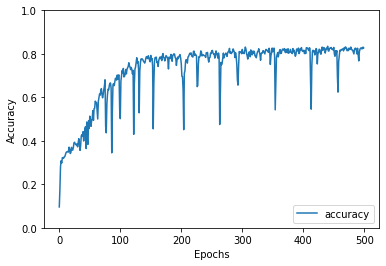

In [19]:
# Evaluation

plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# test_loss, test_acc = model.evaluate(X_test, test_labels_cat, verbose=2)

In [20]:
# print(f'Preciznost na test skupu je: {test_acc}')

In [21]:
# predictions = list(map(lambda x : np.argmax(x), list(model.predict(X_test))))
# real_values = list(y_test['label'])

In [22]:
# for i in range(len(predictions)):
#    print(f'Projektovana vrednost je {predictions[i]} , a stvarna vrednost je {real_values[i]}')

In [26]:
model_path = 'models/categories_network.h5'
model.save(model_path)

! ls models

categories_network.h5


In [27]:
model = None
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               70144     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 107)               54891     
                                                                 
Total params: 585,067
Trainable params: 585,067
Non-trainable params: 0
_________________________________________________________________


In [28]:
# test_loss, test_acc = model.evaluate(X_test, test_labels_cat, verbose=2)